In [1]:
from pathlib import Path
from vesper.models.serialization import create_test_dataset, load_test_dataset
from vesper.models.variants import *
from vesper.models.reads import ReadGroup, AlignedRead
from vesper.models.interval import GenomicInterval
from vesper.models.repeatmasker import RepeatMaskerResult
from vesper.processors.vcf import VCFProcessor
from vesper.processors.reads import ReadProcessor

from vesper.analysis.breakpoint import *
from vesper.analysis.kmer import *

import numpy as np
import pandas as pd

import re
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import font_manager
from matplotlib.transforms import Bbox
import seaborn as sns

# Single column width for most journals is ~3.5 inches
# Double column is ~7 inches
# Nature/Science are slightly different (~89mm and ~183mm)

SINGLE_COL_WIDTH = 3.5  # inches
DOUBLE_COL_WIDTH = 7.0  # inches
MAX_HEIGHT = 9.0  # typical max height for a full page

# Set consistent DPI for both display and saving
SAVE_DPI = 300  # publication quality
mpl.rcParams['figure.dpi'] = 150  # for display
mpl.rcParams['savefig.dpi'] = SAVE_DPI

# Set consistent font sizes that will look good at publication size
mpl.rcParams['font.size'] = 8  # base font size
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['legend.fontsize'] = 6
mpl.rcParams['figure.titlesize'] = 9

# Set consistent line widths and marker sizes
mpl.rcParams['lines.linewidth'] = 1.0
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['axes.linewidth'] = 0.5

# save stock defaults for reference
default_font_family = plt.rcParams['font.family']
default_fonts = plt.rcParams['font.sans-serif'] 

# set default font 
font_path = '/System/Library/Fonts/HelveticaNeue.ttc'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.sans-serif'] = prop.get_name()

# set figure save paths
figure_dir = "/Users/stacy/Documents/Writing/spermSV/Figures/plots"
supp_dir = "/Users/stacy/Documents/Writing/spermSV/Supplement/Figures"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
if not os.path.exists(supp_dir):
    os.makedirs(supp_dir)

# set supp table save path
supp_table_dir = "/Users/stacy/sudmant/manuscript/chapter_3/supp_tables"


In [ ]:
# only run with a new dataset to be saved
# with VCFProcessor(Path('/Users/stacy/sudmant/vesper/output/894.duplomap.annotated.refined.vcf.gz')) as vcf_proc, \
#     ReadProcessor(Path('/Users/stacy/sudmant/vesper/tests/files/hg38/894.duplomap.bam'), registry_dir=Path('/Users/stacy/sudmant/vesper/output/894.duplomap.annotated.refined.read_registry')) as read_proc:
specimens = ['5980', '898', '5619', '899', '895', '5621', 'ASD6058', 'TSC6830', 'TSC7237', 'N22T', 'RG6P', 'SY3L014', '0EL2', 'ASD6463', '0068', '894']

all_variants = []
for specimen in specimens:
    with VCFProcessor(Path(f'/Users/stacy/sudmant/vesper/output/qc_all/{specimen}/{specimen}.duplomap.qc_all.shared.annotated.refined.vcf.gz')) as vcf_proc, \
        ReadProcessor(Path(f'/Volumes/mnemosyne/spermSV/output/alignment/hg38/minimap2/duplomap/mapped/{specimen}/realigned.bam')) as read_proc:
        variants = list(vcf_proc.instantiate_variants())
        for variant in variants:
            support_reads, nonsupport_reads = read_proc.get_read_groups(variant.variant)
            variant.support_reads = support_reads
            variant.nonsupport_reads = nonsupport_reads
            variant._calculate_grouped_metrics()
            variant._calculate_confidence()
        specimen_variants = create_test_dataset(variants, Path(f"/Users/stacy/sudmant/vesper/notebooks/files/{specimen}_variants.pkl"), include_sequence=True)
        all_variants.extend(specimen_variants)
all_variants = create_test_dataset(all_variants, Path(f"/Users/stacy/sudmant/vesper/notebooks/files/all_variants.pkl"), include_sequence=True)

In [4]:
# load dev data

save_data = True

all_variants = load_test_dataset(Path("/Users/stacy/sudmant/vesper/notebooks/files/all_variants.pkl"))
alu_contexts_df = pd.read_csv(f"{supp_table_dir}/alu_features.csv")


BreakPointAnalyzer = BreakpointAnalyzer(reference_fasta = Path("/Users/stacy/sudmant/references/hg38_HGSVC/hg38.no_alt.fa"),
                                        context_size = 50,
                                        debug = True)

def reverse_complement(sequence):
    """Return the reverse complement of a DNA sequence."""
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C',
                 'a': 't', 't': 'a', 'c': 'g', 'g': 'c'}
    return ''.join(complement.get(base, base) for base in sequence[::-1])

def extract_alu_info(variant):
    """Extract Alu-related information from a variant."""
    rm_result = variant.repeatmasker_results[0]
    ins_seq = variant.variant.alt
    
    if rm_result.strand == 'C':
        ins_seq = reverse_complement(ins_seq)
        
    return {
        'repeat_name': rm_result.repeat_name,
        'ins_seq': ins_seq,
        'strand': rm_result.strand,
        'query_start': rm_result.query_start,
        'query_end': rm_result.query_end,
        'repeat_start': rm_result.repeat_start,
        'repeat_end': rm_result.repeat_end,
        'repeat_remaining': rm_result.repeat_left
    }

def create_alu_context_entry(breakpoint, alu_info):
    """Create a dictionary entry for Alu context information."""
    ins_seq = alu_info['ins_seq']
    query_start = alu_info['query_start']
    query_end = alu_info['query_end']
    
    return {
        'ins_name': alu_info['repeat_name'],
        'original_strand': alu_info['strand'],
        'poly_a_tail_seq': breakpoint.poly_a_tail[1],
        'poly_a_tail_start':  breakpoint.poly_a_tail[2][0],
        'poly_a_tail_end':  breakpoint.poly_a_tail[2][1],
        'poly_a_tail_length': breakpoint.poly_a_tail[3],
        'poly_a_tail_impurity': breakpoint.poly_a_tail[4],
        'left_tsd_seq': breakpoint.tsd[1],
        'right_tsd_seq': breakpoint.tsd[2],
        'tsd_length': breakpoint.tsd[3],
        'left_tsd_start': breakpoint.tsd[4][0],
        'left_tsd_end': breakpoint.tsd[4][0] + breakpoint.tsd[3], 
        'right_tsd_start': len(ins_seq) + breakpoint.tsd[4][1], # adjust relative to the insertion seq
        'right_tsd_end': len(ins_seq) + breakpoint.tsd[4][1] + breakpoint.tsd[3], # adjust relative to the insertion seq
        'ins_seq': ins_seq.upper(),
        'ins_seq_length': len(ins_seq),
        'ins_query_start': query_start,
        'ins_query_end': query_end,
        'ins_pre_query': ins_seq[:query_start],
        'ins_match_seq': ins_seq[query_start:query_end],
        'ins_match_length': query_end - query_start,
        'ins_repeat_start': alu_info['repeat_start'],
        'ins_repeat_end': alu_info['repeat_end'],
        'ins_repeat_remaining': alu_info['repeat_remaining'],
        'ins_start_in_read': breakpoint.tsd[5][0],
        'ins_end_in_read': breakpoint.tsd[5][1]
    }

alu_contexts = []
alu_reads = []
for variant in all_variants:
    if variant.repeatmasker_results[0].repeat_class == 'SINE/Alu':
        alu_info = extract_alu_info(variant)
        breakpoint = BreakPointAnalyzer.analyze_breakpoint(variant)

        context_entry = create_alu_context_entry(breakpoint, alu_info)
        if context_entry['original_strand'] == 'C':
            context_entry['ins_seq'] = reverse_complement(context_entry['ins_seq']) # match the sequence in the actual read
        context_entry['variant_id'] = variant.variant.ID
        context_entry['variant_chrom'] = variant.variant.chrom
        context_entry['variant_position'] = variant.variant.position
        alu_contexts.append(context_entry)

        for read in breakpoint.support_reads.reads:
            read_entry = {
                    'variant_id': variant.variant.ID,
                    'read_id': read.name,
                    'read_sequence': read.sequence
                }
            alu_reads.append(read_entry)

alu_features_df = pd.DataFrame(alu_contexts)
alu_reads_df = pd.DataFrame(alu_reads)
alu_features_df = pd.merge(alu_features_df, alu_reads_df, on = 'variant_id')

if save_data:
    export_df = alu_features_df[['variant_id', 'variant_chrom', 'variant_position', 'ins_name', 
                             'original_strand', 'ins_start_in_read', 'ins_end_in_read', 
                             'ins_seq_length', 'ins_seq','ins_query_start', 'ins_query_end', 'ins_match_length',
                             'left_tsd_seq', 'tsd_length','left_tsd_start', 'left_tsd_end', 
                             'right_tsd_start', 'right_tsd_end', 'poly_a_tail_seq', 
                             'poly_a_tail_length', 'poly_a_tail_impurity', 'poly_a_tail_start', 'poly_a_tail_end']]
    export_df.to_csv(f"{supp_table_dir}/alu_features.csv", index = False)
    alu_reads_df.to_csv(f"{supp_table_dir}/alu_support_reads.csv", index = False)

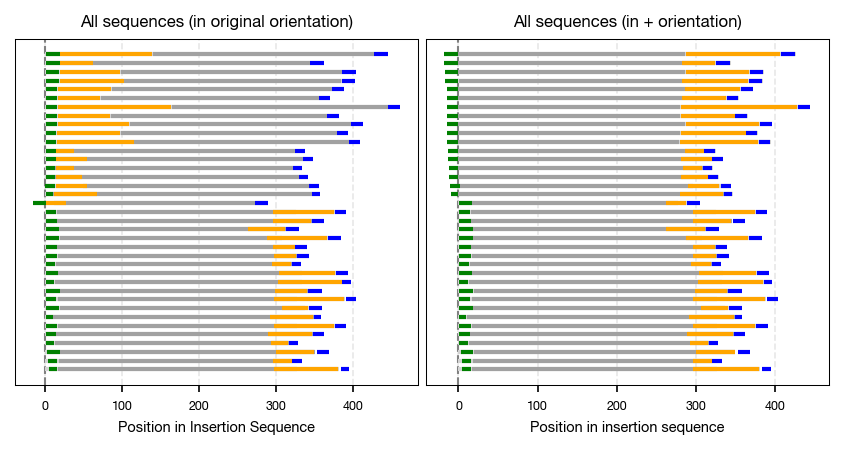

In [ ]:
# test strand flip for visualization

original_df = alu_features_df.copy()
viz_df = alu_features_df.copy()

for idx, row in viz_df.iterrows():
    if row['original_strand'] == 'C':
        seq_len = row['ins_seq_length']
        
        # flip query/alu match coords
        viz_df.loc[idx, 'viz_ins_query_start'] = seq_len - row['ins_query_end']
        viz_df.loc[idx, 'viz_ins_query_end'] = seq_len - row['ins_query_start']
        
        # flip Poly(A) coords
        viz_df.loc[idx, 'viz_poly_a_tail_start'] = seq_len - row['poly_a_tail_end']
        viz_df.loc[idx, 'viz_poly_a_tail_end'] = seq_len - row['poly_a_tail_start']
        
        # flip + swap (left <-> right) TSD coords
        viz_df.loc[idx, 'viz_left_tsd_start'] = seq_len - row['right_tsd_end']
        viz_df.loc[idx, 'viz_left_tsd_end'] = seq_len - row['right_tsd_start']
        viz_df.loc[idx, 'viz_right_tsd_start'] = seq_len - row['left_tsd_end']
        viz_df.loc[idx, 'viz_right_tsd_end'] = seq_len - row['left_tsd_start']
        
    else:
        viz_df.loc[idx, 'viz_ins_query_start'] = row['ins_query_start']
        viz_df.loc[idx, 'viz_ins_query_end'] = row['ins_query_end']
        viz_df.loc[idx, 'viz_poly_a_tail_start'] = row['poly_a_tail_start']
        viz_df.loc[idx, 'viz_poly_a_tail_end'] = row['poly_a_tail_end']
        viz_df.loc[idx, 'viz_left_tsd_start'] = row['left_tsd_start']
        viz_df.loc[idx, 'viz_left_tsd_end'] = row['left_tsd_end']
        viz_df.loc[idx, 'viz_right_tsd_start'] = row['right_tsd_start']
        viz_df.loc[idx, 'viz_right_tsd_end'] = row['right_tsd_end']

sorted_viz_df = viz_df.sort_values(['viz_left_tsd_start', 'original_strand'], 
                                   ascending=[False, True])
original_df = original_df.loc[sorted_viz_df.index] # make comparable

fig, ax = plt.subplots(1, 2, figsize=(DOUBLE_COL_WIDTH, 3), gridspec_kw={'wspace': 0.02})

ax[0].axvline(x=0, color='grey', linestyle='--')

for i, (_, row) in enumerate(original_df.iterrows()):
    ax[0].hlines(y=i, xmin=0, xmax=row.ins_seq_length,
              linewidth=2, color='lightgray')
    ax[0].hlines(y=i, xmin=row.ins_query_start, xmax=row.ins_query_end,
              linewidth=2, color='gray', alpha=0.6)
    ax[0].hlines(y=i, xmin=row.poly_a_tail_start, xmax=row.poly_a_tail_end,
              linewidth=2, color='orange')
    ax[0].hlines(y=i, xmin=row.left_tsd_start, xmax=row.left_tsd_end,
              linewidth=2, color='green')
    ax[0].hlines(y=i, xmin=row.right_tsd_start, xmax=row.right_tsd_end,
              linewidth=2, color='blue')
    
# Uncomment to show the strand labels
# ax[0].set_yticks(range(len(original_df)))
# ax[0].set_yticklabels([f"{row.original_strand}" for _, row in original_df.iterrows()])

ax[0].set_yticks([])
ax[0].set_xlabel('Position in Insertion Sequence')
ax[0].grid(True, alpha=0.3, linestyle='--')
ax[0].set_title('All sequences (in original orientation)')

ax[1].axvline(x=0, color='grey', linestyle='--')

for i, (_, row) in enumerate(sorted_viz_df.iterrows()):
    ax[1].hlines(y=i, xmin=0, xmax=row.ins_seq_length,
              linewidth=2, color='lightgray')
    ax[1].hlines(y=i, xmin=row.viz_ins_query_start, xmax=row.viz_ins_query_end,
              linewidth=2, color='gray', alpha=0.6)
    ax[1].hlines(y=i, xmin=row.viz_poly_a_tail_start, xmax=row.viz_poly_a_tail_end,
              linewidth=2, color='orange')
    ax[1].hlines(y=i, xmin=row.viz_left_tsd_start, xmax=row.viz_left_tsd_end,
              linewidth=2, color='green')
    ax[1].hlines(y=i, xmin=row.viz_right_tsd_start, xmax=row.viz_right_tsd_end,
              linewidth=2, color='blue')
    
# # Uncomment to show the strand labels
# ax[1].set_yticks(range(len(sorted_viz_df)))
# ax[1].set_yticklabels([f"{_}: {row.original_strand}" for _, row in sorted_viz_df.iterrows()])

ax[1].set_yticks([])
ax[1].set_xlabel('Position in insertion sequence')
ax[1].grid(True, alpha=0.3, linestyle='--')
ax[1].set_title('All sequences (in + orientation)')

plt.savefig(f'{supp_dir}/alu_context_viz.png', 
            transparent = True,
            dpi=300)
plt.savefig(f'{supp_dir}/alu_context_viz.pdf',
            bbox_inches = Bbox([[0.65,-0.2],[DOUBLE_COL_WIDTH-0.5, 3]]),
            transparent = True)

In [19]:
# Process each Alu insertion and store in a dataframe
context_analysis = pd.DataFrame({
    'variant_id': [],
    'variant_chrom': [],
    'variant_position': [],
    'original_strand': [],
    'pre_insertion': [],
    'tsd': [],
    'tsd_length': [],
    'post_insertion': [], 
})

for i in alu_features_df.index:
    row = alu_features_df.loc[i]
    
    # Get sequence info
    read_seq = row.read_sequence
    ins_start = row.ins_start_in_read
    
    # Calculate TSD positions
    left_tsd_start = row.left_tsd_start + ins_start
    left_tsd_end = row.left_tsd_end + ins_start
    right_tsd_start = row.right_tsd_start + ins_start 
    right_tsd_end = row.right_tsd_end + ins_start

    # Extract sequences
    pre_seq = read_seq[left_tsd_start-20:left_tsd_start]
    post_seq = read_seq[right_tsd_end:right_tsd_end+20]
    
    # Add row to dataframe
    context_analysis = pd.concat([context_analysis, pd.DataFrame({
        'variant_id': [row.variant_id],
        'variant_chrom': [row.variant_chrom],
        'variant_position': [(row.variant_position)],
        'original_strand': [row.original_strand],
        'pre_insertion': [pre_seq],
        'tsd': [row.right_tsd_seq], 
        'tsd_length': [row.tsd_length],
        'post_insertion': [post_seq],
    })], ignore_index=True)

context_analysis['variant_position'] = context_analysis['variant_position'].astype(int)
context_analysis['tsd_length'] = context_analysis['tsd_length'].astype(int)
context_analysis.to_csv(f"{supp_table_dir}/alu_context_analysis.csv", index=False)

Alright, quick notes before I fry my brain:
* This counters the Levy et al. 2010 model which says that there's a poly-A stretch upstream of the `5'-TT/AAAA-3'` cut site that determines TSD size. 
* In the sense direction, the TSD is duplicated from the *right side* (3' end, past the poly(A) tail) of the insertion in some 7 to 19 bp range. The A-content of the TSD is independent of the poly-A tail length and can be determined by alignment of the insertion context, where the TSD "size" is determined from the right context and mirrored to the left TSD.
* In the antisense directiom, the TSD is duplicated from the *left side* (5' end of the insertion, but equivalent to "past the poly(A) tail" in this direction) of the insertion in a 7-19 bp range. The proposed A-content is T-content (matching the minus sense of the Alu sequence).